In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random

def seed_everything(seed=42):
    """Set random seed for all major libraries"""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hid_size, layers=1, cell='LSTM', dropout=0.0, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.bidirectional = bidirectional
        self.cell_type = cell
        self.layers = layers
        self.hidden_size = hid_size
        
        # Output size will be doubled if bidirectional
        self.output_size = hid_size * 2 if bidirectional else hid_size
        
        rnn_cls = {'LSTM': nn.LSTM, 'GRU': nn.GRU, 'RNN': nn.RNN}[cell]
        self.rnn = rnn_cls(emb_size,
                         hid_size,
                         num_layers=layers,
                         dropout=dropout if layers>1 else 0.0,
                         batch_first=True,
                         bidirectional=bidirectional)

    def forward(self, src, lengths):
        # src: [B, T], lengths: [B]
        embedded = self.embedding(src)  # [B, T, E]
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed)
        outputs, _ = pad_packed_sequence(packed_out, batch_first=True)  # [B, T, H*dirs]
        
        # If bidirectional, we need to process hidden state properly
        if self.bidirectional:
            if self.cell_type == 'LSTM':
                # For LSTM we have both hidden and cell states
                h_n, c_n = hidden
                # Combine forward and backward states by averaging
                h_n = torch.add(h_n[0:self.layers], h_n[self.layers:]) / 2
                c_n = torch.add(c_n[0:self.layers], c_n[self.layers:]) / 2
                hidden = (h_n, c_n)
            else:
                # For GRU/RNN we only have hidden state
                hidden = torch.add(hidden[0:self.layers], hidden[self.layers:]) / 2
                
        return outputs, hidden


class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid, dec_hid):
        super().__init__()
        self.attn = nn.Linear(enc_hid + dec_hid, dec_hid)
        self.v = nn.Linear(dec_hid, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [B, H], encoder_outputs: [B, T, H], mask: [B, T]
        B, T, H = encoder_outputs.size()
        hidden = hidden.unsqueeze(1).repeat(1, T, 1)               # [B, T, H]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [B, T, H]
        scores = self.v(energy).squeeze(2)                        # [B, T]
        scores = scores.masked_fill(~mask, -1e9)
        return torch.softmax(scores, dim=1)                       # [B, T]


class Decoder(nn.Module):
    """
    One class, two modes:
        • use_attn=True  – Bahdanau attention (default)
        • use_attn=False – Plain RNN decoder (no attention)

    Forward always returns (logits, hidden, attn_weights_or_None),
    so Seq2Seq code stays unchanged.
    """
    def __init__(self, vocab_size, emb_size, enc_hid, dec_hid,
                 layers=1, cell="LSTM", dropout=0.0, use_attn=False):
        super().__init__()
        self.use_attn = use_attn
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.cell_type = cell

        # ----- dimensions depend on whether we concatenate context -----
        if use_attn:
            self.attention = BahdanauAttention(enc_hid, dec_hid)
            rnn_input_dim = emb_size + enc_hid            # [E ⊕ Henc]
            fc_input_dim  = dec_hid + enc_hid + emb_size  # [Hdec ⊕ Henc ⊕ E]
        else:
            rnn_input_dim = emb_size
            fc_input_dim  = dec_hid + emb_size

        rnn_cls = {"LSTM": nn.LSTM, "GRU": nn.GRU, "RNN": nn.RNN}[cell]
        self.rnn = rnn_cls(rnn_input_dim, dec_hid,
                           num_layers=layers,
                           dropout=dropout if layers > 1 else 0.0,
                           batch_first=True)
        self.fc = nn.Linear(fc_input_dim, vocab_size)

    def forward(self, input_token, hidden, encoder_outputs, mask):
        """
        input_token : [B]
        hidden      : tuple|tensor  initial state for this step
        encoder_outputs : [B, Tenc, Henc]
        mask        : [B, Tenc]  (ignored when use_attn=False)
        """
        emb = self.embedding(input_token).unsqueeze(1)     # [B,1,E]

        if self.use_attn:
            # ---- additive attention ----
            if self.cell_type == 'LSTM':
                dec_h = hidden[0][-1]
            else:
                dec_h = hidden[-1]
                
            attn_w = self.attention(dec_h, encoder_outputs, mask)          # [B,Tenc]
            ctx    = torch.bmm(attn_w.unsqueeze(1), encoder_outputs)        # [B,1,Henc]
            rnn_in = torch.cat((emb, ctx), dim=2)                           # [B,1,E+Henc]
        else:
            ctx = None
            attn_w = None
            rnn_in = emb                                                    # [B,1,E]

        out, hidden = self.rnn(rnn_in, hidden)       # [B,1,Hdec]
        out = out.squeeze(1)                         # [B,Hdec]
        emb = emb.squeeze(1)                         # [B,E]

        if self.use_attn:
            ctx = ctx.squeeze(1)                     # [B,Henc]
            logits = self.fc(torch.cat((out, ctx, emb), dim=1))
        else:
            logits = self.fc(torch.cat((out, emb), dim=1))

        return logits, hidden, attn_w


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device='cpu'):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device

    def forward(self, src, src_lens, tgt, teacher_forcing_ratio=0.5):
        """
        Enhanced forward with explicit teacher forcing ratio control
        """
        enc_out, hidden = self.encoder(src, src_lens)
        mask = (src != self.pad_idx)
        B, T = tgt.size()
        outputs = torch.zeros(B, T-1, self.decoder.fc.out_features, device=self.device)
        input_tok = tgt[:, 0]  # <sos>
        
        for t in range(1, T):
            out, hidden, _ = self.decoder(input_tok, hidden, enc_out, mask)
            outputs[:, t-1] = out
            
            # Teacher forcing: with probability, use ground truth as next input
            # Otherwise use predicted token
            teacher_force = random.random() < teacher_forcing_ratio
            if teacher_force:
                input_tok = tgt[:, t]
            else:
                input_tok = out.argmax(1)
                
        return outputs

    def infer_greedy(self, src, src_lens, tgt_vocab, max_len=50):
        enc_out, hidden = self.encoder(src, src_lens)
        mask = (src != self.pad_idx)
        B = src.size(0)
        input_tok = torch.full((B,), tgt_vocab.sos_idx, device=self.device, dtype=torch.long)
        generated = []
        
        for _ in range(max_len):
            out, hidden, _ = self.decoder(input_tok, hidden, enc_out, mask)
            input_tok = out.argmax(1)
            generated.append(input_tok.unsqueeze(1))
            if (input_tok == tgt_vocab.eos_idx).all():
                break
                
        return torch.cat(generated, dim=1)

In [2]:
# Downloading dakshina dataset
!yes | wget "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

--2025-05-20 07:07:26--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 173.194.215.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   280MB/s    in 6.9s    

2025-05-20 07:07:33 (277 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]

yes: standard output: Broken pipe


In [3]:
# Unzipping dataset
!yes | tar xopf dakshina_dataset_v1.0.tar

yes: standard output: Broken pipe


In [4]:
# vocab.py - Enhanced vocabulary handling

import json
import os
import pickle

class CharVocab:
    """
    Character-level vocabulary class with additional features from satyabhagwan.ipynb
    """
    def __init__(self, tokens=None, specials=['<pad>','<sos>','<eos>','<unk>']):
        self.specials = specials
        self.idx2char = list(specials) + (tokens or [])
        self.char2idx = {ch:i for i,ch in enumerate(self.idx2char)}

    @classmethod
    def build_from_texts(cls, texts):
        """Build vocabulary from a list of texts"""
        chars = sorted({c for line in texts for c in line})
        return cls(tokens=chars)
    
    @classmethod
    def build_from_file(cls, file_path, src_col='src', tgt_col='trg', is_csv=True):
        """
        Build vocabulary from a data file (CSV or TSV)
        
        Args:
            file_path (str): Path to the data file
            src_col (str): Name of the source column (for CSV)
            tgt_col (str): Name of the target column (for CSV)
            is_csv (bool): Whether the file is CSV (True) or TSV (False)
        """
        if is_csv:
            import pandas as pd
            df = pd.read_csv(file_path, header=None, names=[src_col, tgt_col])
            texts = df[src_col].dropna().tolist() + df[tgt_col].dropna().tolist()
        else:
            texts = []
            with open(file_path, encoding='utf-8') as f:
                for ln in f:
                    parts = ln.strip().split('\t')
                    if len(parts) >= 2:
                        texts.extend([parts[0], parts[1]])
        
        return cls.build_from_texts(texts)

    def save(self, path):
        """Save vocabulary to JSON file"""
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(self.idx2char, f, ensure_ascii=False)

    @classmethod
    def load(cls, path):
        """Load vocabulary from JSON file"""
        with open(path, encoding='utf-8') as f:
            idx2char = json.load(f)
        
        inst = cls(tokens=[])
        inst.idx2char = idx2char
        inst.char2idx = {c:i for i,c in enumerate(idx2char)}
        return inst

    def encode(self, text, add_sos=False, add_eos=False):
        """
        Convert text to a sequence of indices
        
        Args:
            text (str): Input text
            add_sos (bool): Whether to add start-of-sequence token
            add_eos (bool): Whether to add end-of-sequence token
        
        Returns:
            list: Sequence of token indices
        """
        seq = []
        if add_sos: seq.append(self.char2idx['<sos>'])
        for c in text:
            seq.append(self.char2idx.get(c, self.char2idx['<unk>']))
        if add_eos: seq.append(self.char2idx['<eos>'])
        return seq

    def decode(self, idxs, strip_specials=True, join=True):
        """
        Convert a sequence of indices back to text
        
        Args:
            idxs (list or tensor): Sequence of indices
            strip_specials (bool): Whether to remove special tokens
            join (bool): Whether to join characters into a string
            
        Returns:
            str or list: Decoded text as string (if join=True) or list of characters
        """
        # Convert tensor to list if needed
        if hasattr(idxs, 'tolist'):
            idxs = idxs.tolist()
            
        # Convert indices to characters
        chars = [self.idx2char[i] for i in idxs if i < len(self.idx2char)]
        
        # Remove special tokens if requested
        if strip_specials:
            chars = [c for c in chars if c not in self.specials]
            
        # Return as string or list
        return ''.join(chars) if join else chars
    
    def batch_decode(self, batch_idxs, strip_specials=True):
        """
        Decode a batch of index sequences
        
        Args:
            batch_idxs (list of lists or tensor): Batch of index sequences
            strip_specials (bool): Whether to remove special tokens
            
        Returns:
            list: List of decoded strings
        """
        return [self.decode(seq, strip_specials=strip_specials) for seq in batch_idxs]
    
    def get_stats(self):
        """Get vocabulary statistics"""
        return {
            'size': len(self.idx2char),
            'num_specials': len(self.specials),
            'num_chars': len(self.idx2char) - len(self.specials)
        }
    
    def __len__(self):
        return len(self.idx2char)

    @property
    def pad_idx(self): return self.char2idx['<pad>']
    
    @property
    def sos_idx(self): return self.char2idx['<sos>']
    
    @property
    def eos_idx(self): return self.char2idx['<eos>']
    
    @property
    def unk_idx(self): return self.char2idx['<unk>']
    
    @property
    def size(self): return len(self.idx2char)

In [5]:
# data_loader.py - Enhanced data loading with support for multiple datasets

import os
import torch
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
# from vocab import CharVocab

class TransliterationDataset(Dataset):
    """A flexible dataset class that can handle  Dakshina  dataset"""
    
    def __init__(self, path, src_vocab, tgt_vocab, format='dakshina'):
        """
        Initialize the dataset
        
        Args:
            path (str): Path to the data file
            src_vocab (CharVocab): Source vocabulary
            tgt_vocab (CharVocab): Target vocabulary
            format (str): Dataset format - 'dakshina'
        """
        self.examples = []
        self.format = format
        
        if format == 'dakshina':
            # Dakshina format: tab-separated without header
            for src, tgt in read_tsv(path):
                src_ids = src_vocab.encode(src, add_sos=True, add_eos=True)
                tgt_ids = tgt_vocab.encode(tgt, add_sos=True, add_eos=True)
                self.examples.append((
                    torch.tensor(src_ids, dtype=torch.long),
                    torch.tensor(tgt_ids, dtype=torch.long)
                ))
        
        else:
            raise ValueError(f"Unknown format: {format}. Use 'dakshina'")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]


def read_tsv(path):
    """Read a tab-separated file with source and target text"""
    with open(path, encoding='utf-8') as f:
        for ln in f:
            parts = ln.strip().split('\t')
            if len(parts) >= 2:
                yield parts[1], parts[0]  # Dakshina format has target, source


def read_csv(path, src_col='src', tgt_col='trg'):
    """Read a CSV file with source and target columns"""
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        yield row[src_col], row[tgt_col]


def collate_fn(batch, src_vocab, tgt_vocab):
    """Collate function to handle variable-length sequences"""
    srcs, tgts = zip(*batch)
    srcs_p = pad_sequence(srcs, batch_first=True, padding_value=src_vocab.pad_idx)
    tgts_p = pad_sequence(tgts, batch_first=True, padding_value=tgt_vocab.pad_idx)
    src_lens = torch.tensor([len(s) for s in srcs], dtype=torch.long)
    return srcs_p, src_lens, tgts_p


def get_dataloaders(
        language='te', 
        dataset_format='dakshina',
        base_path=None,
        batch_size=64,
        device='cpu',
        num_workers=2,
        prefetch_factor=4,
        persistent_workers=True,
        cache_dir='./cache',
        use_cached_vocab=True
    ):
    
    
    # Set up paths based on dataset format
    if base_path is None:
        base_path = os.path.join(
            '/kaggle/working/dakshina_dataset_v1.0',
            language, 'lexicons'
        )

    # Create cache directory if it doesn't exist
    if use_cached_vocab:
        os.makedirs(cache_dir, exist_ok=True)
        vocab_cache_path = os.path.join(cache_dir, f"{language}_{dataset_format}_vocab.pkl")
    
    # Try to load cached vocabularies
    if use_cached_vocab and os.path.exists(vocab_cache_path):
        print(f"Loading cached vocabularies from {vocab_cache_path}")
        with open(vocab_cache_path, 'rb') as f:
            src_vocab, tgt_vocab = pickle.load(f)
    else:
        # Build vocabularies from data
        all_src, all_tgt = [], []
        
        for split in ['train', 'dev']:
            path = os.path.join(base_path, f"{language}.translit.sampled.{split}.tsv")
            for s, t in read_tsv(path):
                all_src.append(s)
                all_tgt.append(t)
        
        
        # Build vocabularies
        src_vocab = CharVocab.build_from_texts(all_src)
        tgt_vocab = CharVocab.build_from_texts(all_tgt)
        
        # Cache vocabularies
        if use_cached_vocab:
            with open(vocab_cache_path, 'wb') as f:
                pickle.dump((src_vocab, tgt_vocab), f)
    
    # Common DataLoader arguments
    loader_kwargs = dict(
        batch_size=batch_size,
        num_workers=num_workers,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers and num_workers > 0,
        pin_memory=(device == 'cuda')
    )
    
    # Create data loaders for each split
    loaders = {}
    
    
    splits = {'train': 'train', 'dev': 'dev', 'test': 'test'}
    for split_name, file_split in splits.items():
        path = os.path.join(base_path, f"{language}.translit.sampled.{file_split}.tsv")
        ds = TransliterationDataset(path, src_vocab, tgt_vocab, format='dakshina')
        loaders[split_name] = DataLoader(
            ds,
            shuffle=(split_name == 'train'),
            collate_fn=lambda b: collate_fn(b, src_vocab, tgt_vocab),
            **loader_kwargs
        )
    
    
    return loaders, src_vocab, tgt_vocab

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from tqdm.auto import tqdm
import csv
import pandas as pd

def compute_detailed_accuracy(model, loader, tgt_vocab, src_vocab, device):
    """
    Enhanced accuracy function that returns:
    - Overall accuracy
    - Lists of correct and incorrect predictions for analysis
    """
    model.eval()
    correct = total = 0
    
    # Lists to store detailed results
    correct_srcs = []
    correct_tgts = []
    correct_preds = []
    
    incorrect_srcs = []
    incorrect_tgts = []
    incorrect_preds = []
    
    with torch.no_grad():
        for src, src_lens, tgt in loader:
            src, src_lens, tgt = (x.to(device) for x in (src, src_lens, tgt))
            pred = model.infer_greedy(src, src_lens, tgt_vocab, max_len=tgt.size(1))

            # iterate over the batch
            for b in range(src.size(0)):
                # Convert indices to strings
                pred_str = tgt_vocab.decode(pred[b].cpu().tolist())
                gold_str = tgt_vocab.decode(tgt[b, 1:].cpu().tolist())  # skip <sos>
                src_str = src_vocab.decode(src[b].cpu().tolist())
                
                # Check if prediction is correct
                is_correct = (pred_str == gold_str)
                correct += is_correct
                
                # Store detailed results
                if is_correct:
                    correct_srcs.append(src_str)
                    correct_tgts.append(gold_str)
                    correct_preds.append(pred_str)
                else:
                    incorrect_srcs.append(src_str)
                    incorrect_tgts.append(gold_str)
                    incorrect_preds.append(pred_str)
                    
            total += src.size(0)

    accuracy = correct / total if total else 0.0
    return (
        accuracy, 
        (correct_srcs, correct_tgts, correct_preds),
        (incorrect_srcs, incorrect_tgts, incorrect_preds)
    )

def save_predictions_to_csv(src_list, tgt_list, pred_list, file_name):
    """Save prediction details to CSV file for further analysis"""
    rows = zip(src_list, tgt_list, pred_list)
    
    with open(file_name, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Source', 'Target', 'Predicted'])
        writer.writerows(rows)
    
    return file_name

def train_model(
    model, 
    loaders, 
    src_vocab, 
    tgt_vocab, 
    device,
    config,
    save_path=None,
    log_to_wandb=True
):
    """
    Enhanced training function with:
    - Teacher forcing control
    - Detailed accuracy tracking
    - Progress bars
    - Optional WandB logging
    """
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_idx)
    
    # Select optimizer based on config
    if config.optimizer.lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.lr)
    elif config.optimizer.lower() == 'nadam':
        optimizer = optim.NAdam(model.parameters(), lr=config.lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=config.lr)
    
    # Track best validation accuracy
    best_val_acc = 0.0
    
    # Main training loop
    for epoch in tqdm(range(1, config.epochs + 1), desc="Epochs", position=0):
        model.train()
        total_loss = 0.0

        # Training batches with progress bar
        train_loader = tqdm(loaders['train'], desc=f"Train {epoch}", leave=False, position=1)
        for src, src_lens, tgt in train_loader:
            src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)

            optimizer.zero_grad()
            # Use teacher forcing ratio from config
            output = model(src, src_lens, tgt, teacher_forcing_ratio=config.teacher_forcing)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt[:,1:].reshape(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            
        train_loader.close()
        train_loss = total_loss / len(loaders['train'])

        # Validation loss
        val_loss = 0.0
        val_loader = tqdm(loaders['dev'], desc=f"Val {epoch}", leave=False, position=1)
        model.eval()
        with torch.no_grad():
            for src, src_lens, tgt in val_loader:
                src, src_lens, tgt = src.to(device), src_lens.to(device), tgt.to(device)
                output = model(src, src_lens, tgt, teacher_forcing_ratio=0.0)  # No teacher forcing during validation
                val_loss += criterion(output.reshape(-1, output.size(-1)),
                                    tgt[:,1:].reshape(-1)).item()
        val_loader.close()
        val_loss /= len(loaders['dev'])

        # Compute detailed accuracy metrics
        train_results = compute_detailed_accuracy(model, loaders['train'], tgt_vocab, src_vocab, device)
        train_acc = train_results[0]
        
        val_results = compute_detailed_accuracy(model, loaders['dev'], tgt_vocab, src_vocab, device)
        val_acc = val_results[0]
        
        # Save model if it's the best so far
        if val_acc > best_val_acc and save_path:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model with validation accuracy: {val_acc:.4f}")
            
            # Save prediction analysis CSVs for best model
            if epoch == config.epochs or epoch % 5 == 0:  # Save at last epoch or every 5 epochs
                correct_data = val_results[1]
                incorrect_data = val_results[2]
                
                save_predictions_to_csv(
                    correct_data[0], correct_data[1], correct_data[2],
                    f"correct_predictions_epoch_{epoch}.csv"
                )
                
                save_predictions_to_csv(
                    incorrect_data[0], incorrect_data[1], incorrect_data[2],
                    f"incorrect_predictions_epoch_{epoch}.csv"
                )

        # Log metrics
        print(f"Epoch {epoch}/{config.epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if log_to_wandb:
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc*100,
                'val_acc': val_acc*100
            })
    
    # Final evaluation on test set
    # test_results = compute_detailed_accuracy(model, loaders['test'], tgt_vocab, src_vocab, device)
    # test_acc = test_results[0]
    # print(f"Final test accuracy: {test_acc:.4f}")
    
    # if log_to_wandb:
    #     wandb.log({'test_acc': test_acc})
    
    # # Save final prediction analysis
    # correct_data = test_results[1]
    # incorrect_data = test_results[2]
    
    # save_predictions_to_csv(
    #     correct_data[0], correct_data[1], correct_data[2],
    #     "correct_predictions_final.csv"
    # )
    
    # save_predictions_to_csv(
    #     incorrect_data[0], incorrect_data[1], incorrect_data[2],
    #     "incorrect_predictions_final.csv"
    # )
    test_acc=0
    
    return model, test_acc

In [7]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m042 (cs24m042-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
# sweep_config.py - Enhanced with improved hyperparameter sweep

import wandb
import torch
from tqdm.auto import tqdm
import os
import random
import numpy as np


# Import enhanced modules
# from models import Encoder, Decoder, Seq2Seq, seed_everything
# from training import train_model
# from data import get_dataloaders

def objective():
    # Initialize WandB run
    run = wandb.init()
    cfg = run.config
    
    # Set seeds for reproducibility
    seed_everything(cfg.seed if hasattr(cfg, 'seed') else 42)
    
    # Set device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Create a unique run name based on config
    run_name = f"{cfg.cell}_{cfg.enc_layers}l_{cfg.emb_size}e_{cfg.hidden_size}h_" \
               f"{'bid' if cfg.bidirectional else 'uni'}_{cfg.dropout}d_" \
               f"{cfg.teacher_forcing}tf_{cfg.optimizer}"
    wandb.run.name = run_name
    
    # Load data
    loaders, src_vocab, tgt_vocab = get_dataloaders(
        'te',
        batch_size=cfg.batch_size,
        device=device
    )
    
    # Create model components
    enc = Encoder(
        src_vocab.size, cfg.emb_size, cfg.hidden_size,
        cfg.enc_layers, cfg.cell, cfg.dropout, 
        bidirectional=cfg.bidirectional
    ).to(device)
    
    # Calculate encoder output dimension (doubled if bidirectional)
    enc_out_dim = cfg.hidden_size * 2 if cfg.bidirectional else cfg.hidden_size
    
    dec = Decoder(
        tgt_vocab.size, cfg.emb_size, enc_out_dim, cfg.hidden_size,
        cfg.enc_layers, cfg.cell, cfg.dropout
    ).to(device)
    
    model = Seq2Seq(enc, dec, pad_idx=src_vocab.pad_idx, device=device).to(device)
    
    # Train the model
    best_model_path = f"model_{run_name}.pt"
    _, test_acc = train_model(
        model=model,
        loaders=loaders,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        device=device,
        config=cfg,
        save_path=best_model_path,
        log_to_wandb=True
    )
    
    # Log final test accuracy as summary metric
    # wandb.run.summary['test_accuracy'] = test_acc
    
    # Finish the run
    wandb.finish()

if __name__ == "__main__":
    # Define an enhanced sweep configuration
    sweep_cfg = {
        
        'method': 'bayes',  # Use Bayesian optimization
        'name':'Transliteration_without_Attention',
        'metric': {'name': 'val_acc', 'goal': 'maximize'},
        'parameters': {
            
            # Model architecture
            'emb_size': {'values': [128, 256, 512]},
            'hidden_size': {'values': [128, 256, 512, 1024]},
            'enc_layers': {'values': [1, 2, 3, 4]},
            'cell': {'values': ['RNN', 'GRU', 'LSTM']},  
            'bidirectional': {'values': [True, False]},  # Bidirectional encode
            
            # Training parameters
            'dropout': {'values': [0.0, 0.1, 0.2, 0.3, 0.5]},
            'lr': {'values': [1e-4, 2e-4, 5e-4, 8e-4, 1e-3]},
            'batch_size': {'values': [32, 64, 128]},
            'epochs': {'values': [10, 15, 20]},
            'teacher_forcing': {'values': [0.3, 0.5, 0.7, 1.0]},  # Explicit teacher forcing
            'optimizer': {'values': ['Adam', 'NAdam']},  # Added optimizer options
            # Reproducibility
            'seed': {'values': [42, 43, 44, 45, 46]},  # Different seeds for robustness
        }
    }

    # Start the sweep
    sweep_id = wandb.sweep(
        sweep_cfg,
        entity='cs24m042-iit-madras-foundation',  # Replace with your username
        project='DA6401-Assignment-3'
    )
    
    # Run the sweep agent
    wandb.agent('xzm3dimk', function=objective, count=10)

Create sweep with ID: nm9tvk0b
Sweep URL: https://wandb.ai/cs24m042-iit-madras-foundation/DA6401-Assignment-3/sweeps/nm9tvk0b


wandb: Agent Starting Run: g1o47qtp with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	cell: RNN
wandb: 	dropout: 0.1
wandb: 	emb_size: 512
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0005
wandb: 	optimizer: Adam
wandb: 	seed: 42
wandb: 	teacher_forcing: 0.5


Using device: cuda


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train 1:   0%|          | 0/458 [00:00<?, ?it/s]

Val 1:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0004
Epoch 1/15:
  Train Loss: 2.5210, Train Acc: 0.0012
  Val Loss: 2.4871, Val Acc: 0.0004


Train 2:   0%|          | 0/458 [00:00<?, ?it/s]

Val 2:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0076
Epoch 2/15:
  Train Loss: 2.0211, Train Acc: 0.0070
  Val Loss: 2.1479, Val Acc: 0.0076


Train 3:   0%|          | 0/458 [00:00<?, ?it/s]

Val 3:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0120
Epoch 3/15:
  Train Loss: 1.7958, Train Acc: 0.0183
  Val Loss: 2.0417, Val Acc: 0.0120


Train 4:   0%|          | 0/458 [00:00<?, ?it/s]

Val 4:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0238
Epoch 4/15:
  Train Loss: 1.6587, Train Acc: 0.0310
  Val Loss: 1.8903, Val Acc: 0.0238


Train 5:   0%|          | 0/458 [00:00<?, ?it/s]

Val 5:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0345
Epoch 5/15:
  Train Loss: 1.5218, Train Acc: 0.0468
  Val Loss: 1.8053, Val Acc: 0.0345


Train 6:   0%|          | 0/458 [00:00<?, ?it/s]

Val 6:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0521
Epoch 6/15:
  Train Loss: 1.4199, Train Acc: 0.0690
  Val Loss: 1.7175, Val Acc: 0.0521


Train 7:   0%|          | 0/458 [00:00<?, ?it/s]

Val 7:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0649
Epoch 7/15:
  Train Loss: 1.3381, Train Acc: 0.0811
  Val Loss: 1.6404, Val Acc: 0.0649


Train 8:   0%|          | 0/458 [00:00<?, ?it/s]

Val 8:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0695
Epoch 8/15:
  Train Loss: 1.2617, Train Acc: 0.0860
  Val Loss: 1.6284, Val Acc: 0.0695


Train 9:   0%|          | 0/458 [00:00<?, ?it/s]

Val 9:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0919
Epoch 9/15:
  Train Loss: 1.2024, Train Acc: 0.1204
  Val Loss: 1.5128, Val Acc: 0.0919


Train 10:   0%|          | 0/458 [00:00<?, ?it/s]

Val 10:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1056
Epoch 10/15:
  Train Loss: 1.1522, Train Acc: 0.1394
  Val Loss: 1.4812, Val Acc: 0.1056


Train 11:   0%|          | 0/458 [00:00<?, ?it/s]

Val 11:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11/15:
  Train Loss: 1.0992, Train Acc: 0.1360
  Val Loss: 1.4935, Val Acc: 0.0989


Train 12:   0%|          | 0/458 [00:00<?, ?it/s]

Val 12:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1293
Epoch 12/15:
  Train Loss: 1.0580, Train Acc: 0.1711
  Val Loss: 1.3739, Val Acc: 0.1293


Train 13:   0%|          | 0/458 [00:00<?, ?it/s]

Val 13:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13/15:
  Train Loss: 1.0143, Train Acc: 0.1799
  Val Loss: 1.4029, Val Acc: 0.1270


Train 14:   0%|          | 0/458 [00:00<?, ?it/s]

Val 14:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1460
Epoch 14/15:
  Train Loss: 0.9825, Train Acc: 0.1967
  Val Loss: 1.3415, Val Acc: 0.1460


Train 15:   0%|          | 0/458 [00:00<?, ?it/s]

Val 15:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15/15:
  Train Loss: 0.9464, Train Acc: 0.1865
  Val Loss: 1.3323, Val Acc: 0.1401


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▁▂▂▃▃▄▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
val_acc,▁▁▂▂▃▃▄▄▅▆▆▇▇██
val_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
epoch,15
train_acc,18.65243
train_loss,0.94643
val_acc,14.00669
val_loss,1.33232


wandb: Agent Starting Run: r5gfaiar with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	cell: GRU
wandb: 	dropout: 0.1
wandb: 	emb_size: 512
wandb: 	enc_layers: 3
wandb: 	epochs: 20
wandb: 	hidden_size: 512
wandb: 	lr: 0.0001
wandb: 	optimizer: NAdam
wandb: 	seed: 45
wandb: 	teacher_forcing: 0.5


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train 1:   0%|          | 0/458 [00:00<?, ?it/s]

Val 1:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0375
Epoch 1/20:
  Train Loss: 2.2190, Train Acc: 0.0333
  Val Loss: 1.8056, Val Acc: 0.0375


Train 2:   0%|          | 0/458 [00:00<?, ?it/s]

Val 2:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2161
Epoch 2/20:
  Train Loss: 1.1610, Train Acc: 0.2401
  Val Loss: 1.1894, Val Acc: 0.2161


Train 3:   0%|          | 0/458 [00:00<?, ?it/s]

Val 3:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3667
Epoch 3/20:
  Train Loss: 0.7022, Train Acc: 0.4267
  Val Loss: 0.8894, Val Acc: 0.3667


Train 4:   0%|          | 0/458 [00:00<?, ?it/s]

Val 4:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4228
Epoch 4/20:
  Train Loss: 0.4916, Train Acc: 0.5270
  Val Loss: 0.7624, Val Acc: 0.4228


Train 5:   0%|          | 0/458 [00:00<?, ?it/s]

Val 5:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5/20:
  Train Loss: 0.3749, Train Acc: 0.5206
  Val Loss: 0.7126, Val Acc: 0.3945


Train 6:   0%|          | 0/458 [00:00<?, ?it/s]

Val 6:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 6/20:
  Train Loss: 0.3098, Train Acc: 0.5770
  Val Loss: 0.7196, Val Acc: 0.4072


Train 7:   0%|          | 0/458 [00:00<?, ?it/s]

Val 7:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4392
Epoch 7/20:
  Train Loss: 0.2506, Train Acc: 0.6267
  Val Loss: 0.7231, Val Acc: 0.4392


Train 8:   0%|          | 0/458 [00:00<?, ?it/s]

Val 8:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 8/20:
  Train Loss: 0.2114, Train Acc: 0.5729
  Val Loss: 0.7048, Val Acc: 0.3928


Train 9:   0%|          | 0/458 [00:00<?, ?it/s]

Val 9:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4670
Epoch 9/20:
  Train Loss: 0.1832, Train Acc: 0.6843
  Val Loss: 0.7025, Val Acc: 0.4670


Train 10:   0%|          | 0/458 [00:00<?, ?it/s]

Val 10:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 10/20:
  Train Loss: 0.1538, Train Acc: 0.6540
  Val Loss: 0.7399, Val Acc: 0.4512


Train 11:   0%|          | 0/458 [00:00<?, ?it/s]

Val 11:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11/20:
  Train Loss: 0.1316, Train Acc: 0.2435
  Val Loss: 0.7257, Val Acc: 0.2363


Train 12:   0%|          | 0/458 [00:00<?, ?it/s]

Val 12:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12/20:
  Train Loss: 0.1138, Train Acc: 0.4199
  Val Loss: 0.7543, Val Acc: 0.3127


Train 13:   0%|          | 0/458 [00:00<?, ?it/s]

Val 13:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 13/20:
  Train Loss: 0.0982, Train Acc: 0.3424
  Val Loss: 0.7901, Val Acc: 0.2530


Train 14:   0%|          | 0/458 [00:00<?, ?it/s]

Val 14:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4973
Epoch 14/20:
  Train Loss: 0.0857, Train Acc: 0.8101
  Val Loss: 0.8010, Val Acc: 0.4973


Train 15:   0%|          | 0/458 [00:00<?, ?it/s]

Val 15:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 15/20:
  Train Loss: 0.0747, Train Acc: 0.3339
  Val Loss: 0.8222, Val Acc: 0.2541


Train 16:   0%|          | 0/458 [00:00<?, ?it/s]

Val 16:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 16/20:
  Train Loss: 0.0641, Train Acc: 0.6768
  Val Loss: 0.8245, Val Acc: 0.4214


Train 17:   0%|          | 0/458 [00:00<?, ?it/s]

Val 17:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 17/20:
  Train Loss: 0.0566, Train Acc: 0.4398
  Val Loss: 0.8332, Val Acc: 0.2967


Train 18:   0%|          | 0/458 [00:00<?, ?it/s]

Val 18:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 18/20:
  Train Loss: 0.0523, Train Acc: 0.6974
  Val Loss: 0.8719, Val Acc: 0.4251


Train 19:   0%|          | 0/458 [00:00<?, ?it/s]

Val 19:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 19/20:
  Train Loss: 0.0488, Train Acc: 0.4932
  Val Loss: 0.9052, Val Acc: 0.2977


Train 20:   0%|          | 0/458 [00:00<?, ?it/s]

Val 20:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.5052
Epoch 20/20:
  Train Loss: 0.0432, Train Acc: 0.8433
  Val Loss: 0.8961, Val Acc: 0.5052


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▃▄▅▅▆▆▆▇▆▃▄▄█▄▇▅▇▅█
train_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▇▆▇▇▆▇▇▄▅▄█▄▇▅▇▅█
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
epoch,20
train_acc,84.32963
train_loss,0.04317
val_acc,50.51909
val_loss,0.89607


wandb: Agent Starting Run: 5tiic273 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: False
wandb: 	cell: GRU
wandb: 	dropout: 0
wandb: 	emb_size: 512
wandb: 	enc_layers: 4
wandb: 	epochs: 10
wandb: 	hidden_size: 1024
wandb: 	lr: 0.0002
wandb: 	optimizer: Adam
wandb: 	seed: 46
wandb: 	teacher_forcing: 0.7


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/915 [00:00<?, ?it/s]

Val 1:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1841
Epoch 1/10:
  Train Loss: 0.8800, Train Acc: 0.2158
  Val Loss: 0.8023, Val Acc: 0.1841


Train 2:   0%|          | 0/915 [00:00<?, ?it/s]

Val 2:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4888
Epoch 2/10:
  Train Loss: 0.2493, Train Acc: 0.6581
  Val Loss: 0.7684, Val Acc: 0.4888


Train 3:   0%|          | 0/915 [00:00<?, ?it/s]

Val 3:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3/10:
  Train Loss: 0.1529, Train Acc: 0.2767
  Val Loss: 0.7410, Val Acc: 0.2140


Train 4:   0%|          | 0/915 [00:00<?, ?it/s]

Val 4:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4/10:
  Train Loss: 0.1044, Train Acc: 0.4409
  Val Loss: 0.7685, Val Acc: 0.3092


Train 5:   0%|          | 0/915 [00:00<?, ?it/s]

Val 5:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 0.0758, Train Acc: 0.2623
  Val Loss: 0.8232, Val Acc: 0.1821


Train 6:   0%|          | 0/915 [00:00<?, ?it/s]

Val 6:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6/10:
  Train Loss: 0.0607, Train Acc: 0.4252
  Val Loss: 0.8410, Val Acc: 0.2671


Train 7:   0%|          | 0/915 [00:00<?, ?it/s]

Val 7:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4908
Epoch 7/10:
  Train Loss: 0.0486, Train Acc: 0.7154
  Val Loss: 0.8941, Val Acc: 0.4908


Train 8:   0%|          | 0/915 [00:00<?, ?it/s]

Val 8:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8/10:
  Train Loss: 0.0412, Train Acc: 0.3218
  Val Loss: 0.9183, Val Acc: 0.2344


Train 9:   0%|          | 0/915 [00:00<?, ?it/s]

Val 9:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9/10:
  Train Loss: 0.0360, Train Acc: 0.4560
  Val Loss: 0.9177, Val Acc: 0.3166


Train 10:   0%|          | 0/915 [00:00<?, ?it/s]

Val 10:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10/10:
  Train Loss: 0.0348, Train Acc: 0.4913
  Val Loss: 0.9286, Val Acc: 0.3250


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▇▂▄▂▄█▂▄▅
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁█▂▄▁▃█▂▄▄
val_loss,▃▂▁▂▄▅▇███
epoch,10
train_acc,49.12724
train_loss,0.03481
val_acc,32.50044
val_loss,0.92861


wandb: Agent Starting Run: sad5f7xp with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: True
wandb: 	cell: RNN
wandb: 	dropout: 0
wandb: 	emb_size: 128
wandb: 	enc_layers: 1
wandb: 	epochs: 20
wandb: 	hidden_size: 1024
wandb: 	lr: 0.0002
wandb: 	optimizer: NAdam
wandb: 	seed: 45
wandb: 	teacher_forcing: 0.3


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train 1:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 1:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1314
Epoch 1/20:
  Train Loss: 1.5977, Train Acc: 0.1106
  Val Loss: 1.1849, Val Acc: 0.1314


Train 2:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 2:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2071
Epoch 2/20:
  Train Loss: 0.8108, Train Acc: 0.2459
  Val Loss: 0.9441, Val Acc: 0.2071


Train 3:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 3:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2122
Epoch 3/20:
  Train Loss: 0.5727, Train Acc: 0.2304
  Val Loss: 0.8925, Val Acc: 0.2122


Train 4:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 4:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2469
Epoch 4/20:
  Train Loss: 0.4458, Train Acc: 0.2821
  Val Loss: 0.8914, Val Acc: 0.2469


Train 5:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 5:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 5/20:
  Train Loss: 0.3596, Train Acc: 0.2514
  Val Loss: 0.8848, Val Acc: 0.2233


Train 6:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 6:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 6/20:
  Train Loss: 0.2904, Train Acc: 0.3112
  Val Loss: 0.9179, Val Acc: 0.2442


Train 7:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 7:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 7/20:
  Train Loss: 0.2427, Train Acc: 0.1947
  Val Loss: 0.9345, Val Acc: 0.1804


Train 8:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 8:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2634
Epoch 8/20:
  Train Loss: 0.2059, Train Acc: 0.3588
  Val Loss: 0.9673, Val Acc: 0.2634


Train 9:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 9:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 9/20:
  Train Loss: 0.1748, Train Acc: 0.3516
  Val Loss: 0.9790, Val Acc: 0.2587


Train 10:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 10:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 10/20:
  Train Loss: 0.1552, Train Acc: 0.2826
  Val Loss: 1.0292, Val Acc: 0.2134


Train 11:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 11:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 11/20:
  Train Loss: 0.1364, Train Acc: 0.3650
  Val Loss: 1.0577, Val Acc: 0.2416


Train 12:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 12:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 12/20:
  Train Loss: 0.1230, Train Acc: 0.3257
  Val Loss: 1.0701, Val Acc: 0.2272


Train 13:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 13:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 13/20:
  Train Loss: 0.1103, Train Acc: 0.2359
  Val Loss: 1.1040, Val Acc: 0.1682


Train 14:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 14:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 14/20:
  Train Loss: 0.1009, Train Acc: 0.2830
  Val Loss: 1.1856, Val Acc: 0.2110


Train 15:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 15:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 15/20:
  Train Loss: 0.0952, Train Acc: 0.1956
  Val Loss: 1.1962, Val Acc: 0.1603


Train 16:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 16:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 16/20:
  Train Loss: 0.0895, Train Acc: 0.2556
  Val Loss: 1.1682, Val Acc: 0.1936


Train 17:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 17:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 17/20:
  Train Loss: 0.0844, Train Acc: 0.1561
  Val Loss: 1.2313, Val Acc: 0.1265


Train 18:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 18:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 18/20:
  Train Loss: 0.0799, Train Acc: 0.2914
  Val Loss: 1.2002, Val Acc: 0.1946


Train 19:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 19:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 19/20:
  Train Loss: 0.0782, Train Acc: 0.2217
  Val Loss: 1.2932, Val Acc: 0.1682


Train 20:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 20:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 20/20:
  Train Loss: 0.0747, Train Acc: 0.2885
  Val Loss: 1.2828, Val Acc: 0.2045


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▅▄▆▅▇▃██▆█▇▄▆▃▅▂▆▄▆
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▅▇▆▇▄██▅▇▆▃▅▃▄▁▄▃▅
val_loss,▆▂▁▁▁▂▂▂▃▃▄▄▅▆▆▆▇▆██
epoch,20
train_acc,28.84885
train_loss,0.07465
val_acc,20.44695
val_loss,1.28278


wandb: Agent Starting Run: tetydt23 with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: True
wandb: 	cell: LSTM
wandb: 	dropout: 0.5
wandb: 	emb_size: 512
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	optimizer: NAdam
wandb: 	seed: 46
wandb: 	teacher_forcing: 0.3


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train 1:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 1:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3605
Epoch 1/15:
  Train Loss: 0.9396, Train Acc: 0.4346
  Val Loss: 0.7025, Val Acc: 0.3605


Train 2:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 2:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3868
Epoch 2/15:
  Train Loss: 0.4398, Train Acc: 0.4711
  Val Loss: 0.5921, Val Acc: 0.3868


Train 3:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 3:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4519
Epoch 3/15:
  Train Loss: 0.3480, Train Acc: 0.6254
  Val Loss: 0.6019, Val Acc: 0.4519


Train 4:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 4:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 4/15:
  Train Loss: 0.3008, Train Acc: 0.5025
  Val Loss: 0.6073, Val Acc: 0.3788


Train 5:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 5:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 5/15:
  Train Loss: 0.2675, Train Acc: 0.5194
  Val Loss: 0.6221, Val Acc: 0.3734


Train 6:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 6:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 6/15:
  Train Loss: 0.2389, Train Acc: 0.4335
  Val Loss: 0.6215, Val Acc: 0.3373


Train 7:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 7:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 7/15:
  Train Loss: 0.2176, Train Acc: 0.4576
  Val Loss: 0.6425, Val Acc: 0.3489


Train 8:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 8:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4677
Epoch 8/15:
  Train Loss: 0.2052, Train Acc: 0.6978
  Val Loss: 0.6229, Val Acc: 0.4677


Train 9:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 9:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 9/15:
  Train Loss: 0.1926, Train Acc: 0.4410
  Val Loss: 0.6454, Val Acc: 0.3195


Train 10:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 10:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 10/15:
  Train Loss: 0.1797, Train Acc: 0.7092
  Val Loss: 0.6530, Val Acc: 0.4658


Train 11:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 11:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 11/15:
  Train Loss: 0.1714, Train Acc: 0.6113
  Val Loss: 0.6716, Val Acc: 0.4100


Train 12:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 12:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 12/15:
  Train Loss: 0.1657, Train Acc: 0.7275
  Val Loss: 0.6743, Val Acc: 0.4552


Train 13:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 13:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 13/15:
  Train Loss: 0.1598, Train Acc: 0.6508
  Val Loss: 0.6715, Val Acc: 0.4373


Train 14:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 14:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 14/15:
  Train Loss: 0.1511, Train Acc: 0.6733
  Val Loss: 0.6841, Val Acc: 0.4345


Train 15:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 15:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 15/15:
  Train Loss: 0.1482, Train Acc: 0.3768
  Val Loss: 0.6882, Val Acc: 0.2550


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▂▃▆▄▄▂▃▇▂█▆█▆▇▁
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▄▅▇▅▅▄▄█▃█▆█▇▇▁
val_loss,█▁▂▂▃▃▄▃▄▅▆▆▆▇▇
epoch,15
train_acc,37.68403
train_loss,0.14824
val_acc,25.4971
val_loss,0.68822


wandb: Agent Starting Run: copka5cq with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: False
wandb: 	cell: RNN
wandb: 	dropout: 0.1
wandb: 	emb_size: 512
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	lr: 0.0001
wandb: 	optimizer: NAdam
wandb: 	seed: 44
wandb: 	teacher_forcing: 0.3


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 1:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 1/10:
  Train Loss: 2.9495, Train Acc: 0.0000
  Val Loss: 2.9427, Val Acc: 0.0000


Train 2:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 2:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 2/10:
  Train Loss: 2.7451, Train Acc: 0.0000
  Val Loss: 2.8968, Val Acc: 0.0000


Train 3:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 3:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 3/10:
  Train Loss: 2.6931, Train Acc: 0.0001
  Val Loss: 2.8108, Val Acc: 0.0000


Train 4:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 4:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 4/10:
  Train Loss: 2.6136, Train Acc: 0.0002
  Val Loss: 2.7618, Val Acc: 0.0000


Train 5:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 5:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 2.5650, Train Acc: 0.0001
  Val Loss: 2.7204, Val Acc: 0.0000


Train 6:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 6:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 6/10:
  Train Loss: 2.5307, Train Acc: 0.0001
  Val Loss: 2.6789, Val Acc: 0.0000


Train 7:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 7:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 7/10:
  Train Loss: 2.4970, Train Acc: 0.0002
  Val Loss: 2.6693, Val Acc: 0.0000


Train 8:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 8:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 8/10:
  Train Loss: 2.4716, Train Acc: 0.0002
  Val Loss: 2.6449, Val Acc: 0.0000


Train 9:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 9:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0002
Epoch 9/10:
  Train Loss: 2.4451, Train Acc: 0.0003
  Val Loss: 2.6409, Val Acc: 0.0002


Train 10:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 10:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 10/10:
  Train Loss: 2.4264, Train Acc: 0.0002
  Val Loss: 2.5967, Val Acc: 0.0000


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▄▄▃▄▆▇█▆
train_loss,█▅▅▄▃▂▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁█▁
val_loss,█▇▅▄▄▃▂▂▂▁
epoch,10
train_acc,0.0205
train_loss,2.42642
val_acc,0
val_loss,2.5967


wandb: Agent Starting Run: 7df7k6k8 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	cell: RNN
wandb: 	dropout: 0.1
wandb: 	emb_size: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_size: 1024
wandb: 	lr: 0.0001
wandb: 	optimizer: NAdam
wandb: 	seed: 46
wandb: 	teacher_forcing: 0.7


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/915 [00:00<?, ?it/s]

Val 1:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0864
Epoch 1/10:
  Train Loss: 1.6033, Train Acc: 0.0902
  Val Loss: 1.4345, Val Acc: 0.0864


Train 2:   0%|          | 0/915 [00:00<?, ?it/s]

Val 2:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0948
Epoch 2/10:
  Train Loss: 0.7370, Train Acc: 0.0705
  Val Loss: 1.0890, Val Acc: 0.0948


Train 3:   0%|          | 0/915 [00:00<?, ?it/s]

Val 3:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1096
Epoch 3/10:
  Train Loss: 0.4963, Train Acc: 0.0569
  Val Loss: 0.9972, Val Acc: 0.1096


Train 4:   0%|          | 0/915 [00:00<?, ?it/s]

Val 4:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1422
Epoch 4/10:
  Train Loss: 0.3673, Train Acc: 0.1047
  Val Loss: 0.9221, Val Acc: 0.1422


Train 5:   0%|          | 0/915 [00:00<?, ?it/s]

Val 5:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 0.2916, Train Acc: 0.1227
  Val Loss: 0.9496, Val Acc: 0.1163


Train 6:   0%|          | 0/915 [00:00<?, ?it/s]

Val 6:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6/10:
  Train Loss: 0.2317, Train Acc: 0.0731
  Val Loss: 0.9552, Val Acc: 0.0899


Train 7:   0%|          | 0/915 [00:00<?, ?it/s]

Val 7:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1608
Epoch 7/10:
  Train Loss: 0.1884, Train Acc: 0.2057
  Val Loss: 0.9774, Val Acc: 0.1608


Train 8:   0%|          | 0/915 [00:00<?, ?it/s]

Val 8:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8/10:
  Train Loss: 0.1541, Train Acc: 0.1956
  Val Loss: 1.0203, Val Acc: 0.1605


Train 9:   0%|          | 0/915 [00:00<?, ?it/s]

Val 9:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9/10:
  Train Loss: 0.1286, Train Acc: 0.1692
  Val Loss: 1.0244, Val Acc: 0.1446


Train 10:   0%|          | 0/915 [00:00<?, ?it/s]

Val 10:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10/10:
  Train Loss: 0.1083, Train Acc: 0.0875
  Val Loss: 1.0689, Val Acc: 0.0802


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▃▂▁▃▄▂██▆▂
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▂▂▄▆▄▂██▇▁
val_loss,█▃▂▁▁▁▂▂▂▃
epoch,10
train_acc,8.75149
train_loss,0.10829
val_acc,8.02393
val_loss,1.0689


wandb: Agent Starting Run: a2z8glo6 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	cell: GRU
wandb: 	dropout: 0
wandb: 	emb_size: 512
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0008
wandb: 	optimizer: NAdam
wandb: 	seed: 43
wandb: 	teacher_forcing: 0.3


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train 1:   0%|          | 0/915 [00:00<?, ?it/s]

Val 1:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0558
Epoch 1/15:
  Train Loss: 1.9001, Train Acc: 0.0649
  Val Loss: 1.5275, Val Acc: 0.0558


Train 2:   0%|          | 0/915 [00:00<?, ?it/s]

Val 2:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.1647
Epoch 2/15:
  Train Loss: 1.1620, Train Acc: 0.1838
  Val Loss: 1.2308, Val Acc: 0.1647


Train 3:   0%|          | 0/915 [00:00<?, ?it/s]

Val 3:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2427
Epoch 3/15:
  Train Loss: 0.9281, Train Acc: 0.2707
  Val Loss: 1.0791, Val Acc: 0.2427


Train 4:   0%|          | 0/915 [00:00<?, ?it/s]

Val 4:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2631
Epoch 4/15:
  Train Loss: 0.8036, Train Acc: 0.3312
  Val Loss: 1.0543, Val Acc: 0.2631


Train 5:   0%|          | 0/915 [00:00<?, ?it/s]

Val 5:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2861
Epoch 5/15:
  Train Loss: 0.7292, Train Acc: 0.3579
  Val Loss: 0.9872, Val Acc: 0.2861


Train 6:   0%|          | 0/915 [00:00<?, ?it/s]

Val 6:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3002
Epoch 6/15:
  Train Loss: 0.6732, Train Acc: 0.3943
  Val Loss: 0.9895, Val Acc: 0.3002


Train 7:   0%|          | 0/915 [00:00<?, ?it/s]

Val 7:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3123
Epoch 7/15:
  Train Loss: 0.6319, Train Acc: 0.4202
  Val Loss: 0.9676, Val Acc: 0.3123


Train 8:   0%|          | 0/915 [00:00<?, ?it/s]

Val 8:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3306
Epoch 8/15:
  Train Loss: 0.6035, Train Acc: 0.4499
  Val Loss: 0.9448, Val Acc: 0.3306


Train 9:   0%|          | 0/915 [00:00<?, ?it/s]

Val 9:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9/15:
  Train Loss: 0.5717, Train Acc: 0.4527
  Val Loss: 0.9810, Val Acc: 0.3262


Train 10:   0%|          | 0/915 [00:00<?, ?it/s]

Val 10:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10/15:
  Train Loss: 0.5528, Train Acc: 0.4341
  Val Loss: 0.9333, Val Acc: 0.3099


Train 11:   0%|          | 0/915 [00:00<?, ?it/s]

Val 11:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3407
Epoch 11/15:
  Train Loss: 0.5329, Train Acc: 0.4844
  Val Loss: 0.9163, Val Acc: 0.3407


Train 12:   0%|          | 0/915 [00:00<?, ?it/s]

Val 12:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3510
Epoch 12/15:
  Train Loss: 0.5146, Train Acc: 0.5048
  Val Loss: 0.9110, Val Acc: 0.3510


Train 13:   0%|          | 0/915 [00:00<?, ?it/s]

Val 13:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3535
Epoch 13/15:
  Train Loss: 0.4947, Train Acc: 0.5211
  Val Loss: 0.9354, Val Acc: 0.3535


Train 14:   0%|          | 0/915 [00:00<?, ?it/s]

Val 14:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3546
Epoch 14/15:
  Train Loss: 0.4854, Train Acc: 0.5240
  Val Loss: 0.9221, Val Acc: 0.3546


Train 15:   0%|          | 0/915 [00:00<?, ?it/s]

Val 15:   0%|          | 0/89 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3605
Epoch 15/15:
  Train Loss: 0.4712, Train Acc: 0.5341
  Val Loss: 0.9221, Val Acc: 0.3605


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▄▅▅▆▆▇▇▇▇████
train_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇▇█████
val_loss,█▅▃▃▂▂▂▁▂▁▁▁▁▁▁
epoch,15
train_acc,53.41247
train_loss,0.47122
val_acc,36.0549
val_loss,0.92207


wandb: Agent Starting Run: vzeeh3gg with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: False
wandb: 	cell: GRU
wandb: 	dropout: 0.5
wandb: 	emb_size: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.0005
wandb: 	optimizer: Adam
wandb: 	seed: 44
wandb: 	teacher_forcing: 0.3


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train 1:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 1:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2933
Epoch 1/15:
  Train Loss: 1.4555, Train Acc: 0.3109
  Val Loss: 0.8907, Val Acc: 0.2933


Train 2:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 2:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4014
Epoch 2/15:
  Train Loss: 0.7243, Train Acc: 0.4775
  Val Loss: 0.7725, Val Acc: 0.4014


Train 3:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 3:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4367
Epoch 3/15:
  Train Loss: 0.5725, Train Acc: 0.5560
  Val Loss: 0.7201, Val Acc: 0.4367


Train 4:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 4:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4726
Epoch 4/15:
  Train Loss: 0.4912, Train Acc: 0.6235
  Val Loss: 0.6450, Val Acc: 0.4726


Train 5:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 5:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4848
Epoch 5/15:
  Train Loss: 0.4390, Train Acc: 0.6661
  Val Loss: 0.6504, Val Acc: 0.4848


Train 6:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 6:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4964
Epoch 6/15:
  Train Loss: 0.3976, Train Acc: 0.6820
  Val Loss: 0.6667, Val Acc: 0.4964


Train 7:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 7:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.5191
Epoch 7/15:
  Train Loss: 0.3673, Train Acc: 0.7192
  Val Loss: 0.6103, Val Acc: 0.5191


Train 8:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 8:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 8/15:
  Train Loss: 0.3492, Train Acc: 0.7364
  Val Loss: 0.6040, Val Acc: 0.5156


Train 9:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 9:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 9/15:
  Train Loss: 0.3302, Train Acc: 0.6988
  Val Loss: 0.6039, Val Acc: 0.5173


Train 10:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 10:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.5275
Epoch 10/15:
  Train Loss: 0.3123, Train Acc: 0.7568
  Val Loss: 0.6245, Val Acc: 0.5275


Train 11:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 11:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 11/15:
  Train Loss: 0.2979, Train Acc: 0.7888
  Val Loss: 0.6366, Val Acc: 0.5261


Train 12:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 12:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.5349
Epoch 12/15:
  Train Loss: 0.2873, Train Acc: 0.7949
  Val Loss: 0.6307, Val Acc: 0.5349


Train 13:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 13:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.5469
Epoch 13/15:
  Train Loss: 0.2769, Train Acc: 0.8042
  Val Loss: 0.6191, Val Acc: 0.5469


Train 14:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 14:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 14/15:
  Train Loss: 0.2683, Train Acc: 0.8141
  Val Loss: 0.6388, Val Acc: 0.5335


Train 15:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 15:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 15/15:
  Train Loss: 0.2613, Train Acc: 0.8107
  Val Loss: 0.6529, Val Acc: 0.5358


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▄▅▆▆▇▇▆▇█████
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇▇▇████
val_loss,█▅▄▂▂▃▁▁▁▂▂▂▁▂▂
epoch,15
train_acc,81.06576
train_loss,0.26129
val_acc,53.58086
val_loss,0.65288


wandb: Agent Starting Run: 1z2d3k9d with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: False
wandb: 	cell: GRU
wandb: 	dropout: 0
wandb: 	emb_size: 256
wandb: 	enc_layers: 4
wandb: 	epochs: 10
wandb: 	hidden_size: 256
wandb: 	lr: 0.0001
wandb: 	optimizer: NAdam
wandb: 	seed: 44
wandb: 	teacher_forcing: 0.3


Using device: cuda
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 1:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.0278
Epoch 1/10:
  Train Loss: 2.3378, Train Acc: 0.0277
  Val Loss: 1.6838, Val Acc: 0.0278


Train 2:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 2:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.2099
Epoch 2/10:
  Train Loss: 1.2052, Train Acc: 0.2287
  Val Loss: 1.0382, Val Acc: 0.2099


Train 3:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 3:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3361
Epoch 3/10:
  Train Loss: 0.7655, Train Acc: 0.3797
  Val Loss: 0.8394, Val Acc: 0.3361


Train 4:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 4:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.3889
Epoch 4/10:
  Train Loss: 0.5787, Train Acc: 0.4740
  Val Loss: 0.7698, Val Acc: 0.3889


Train 5:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 5:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4434
Epoch 5/10:
  Train Loss: 0.4809, Train Acc: 0.5528
  Val Loss: 0.6853, Val Acc: 0.4434


Train 6:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 6:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4542
Epoch 6/10:
  Train Loss: 0.4125, Train Acc: 0.5921
  Val Loss: 0.6784, Val Acc: 0.4542


Train 7:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 7:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4753
Epoch 7/10:
  Train Loss: 0.3572, Train Acc: 0.6246
  Val Loss: 0.6356, Val Acc: 0.4753


Train 8:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 8:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.4776
Epoch 8/10:
  Train Loss: 0.3152, Train Acc: 0.6308
  Val Loss: 0.6401, Val Acc: 0.4776


Train 9:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 9:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 9/10:
  Train Loss: 0.2797, Train Acc: 0.6556
  Val Loss: 0.6399, Val Acc: 0.4749


Train 10:   0%|          | 0/1830 [00:00<?, ?it/s]

Val 10:   0%|          | 0/178 [00:00<?, ?it/s]

Saved new best model with validation accuracy: 0.5020
Epoch 10/10:
  Train Loss: 0.2486, Train Acc: 0.7013
  Val Loss: 0.6482, Val Acc: 0.5020


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▄▆▆▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,70.12639
train_loss,0.24856
val_acc,50.20236
val_loss,0.64821


In [4]:
!python /kaggle/input/code/pytorch/default/1/DA6401-Assignment3-main/train.py -e 2 -br /kaggle/working/dakshina_dataset_v1.0/te/lexicons

Using device: cuda
wandb: Currently logged in as: cs24m042 (cs24m042-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250519_224532-0ocaous8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run te_LSTM_2l_256emb_512hid_uni_attn_adam_lr0.001_tf0.5
wandb: ⭐️ View project at https://wandb.ai/cs24m042-iit-madras-foundation/DA6401-Assignment-3
wandb: 🚀 View run at https://wandb.ai/cs24m042-iit-madras-foundation/DA6401-Assignment-3/runs/0ocaous8
Loading te data...
Source vocabulary size: 30
Target vocabulary size: 67
Training examples: 58550
Validation examples: 5683
Test examples: 5747
Building model...
Training model...
Train 1: 100%|███████████████████████████████▉| 913/915 [00:47<00:00, 19.49it/s]
                                                                                
Val 1: 100%|██████████████████████████████████

In [5]:
!python /kaggle/input/code/pytorch/default/1/DA6401-Assignment3-main/train.py -e 2 -br /kaggle/working/dakshina_dataset_v1.0/te/lexicons -att false

Using device: cuda
wandb: Currently logged in as: cs24m042 (cs24m042-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250519_225338-46kzedwt
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run te_LSTM_2l_256emb_512hid_uni_plain_adam_lr0.001_tf0.5
wandb: ⭐️ View project at https://wandb.ai/cs24m042-iit-madras-foundation/DA6401-Assignment-3
wandb: 🚀 View run at https://wandb.ai/cs24m042-iit-madras-foundation/DA6401-Assignment-3/runs/46kzedwt
Loading te data...
Loading cached vocabularies from ./cache/te_dakshina_vocab.pkl
Source vocabulary size: 30
Target vocabulary size: 67
Training examples: 58550
Validation examples: 5683
Test examples: 5747
Building model...
Training model...
Train 1: 100%|███████████████████████████████▉| 914/915 [00:32<00:00, 27.98it/s]
                                                               

In [ ]:
import wandb
import pandas as pd
from pathlib import Path

def create_comparison_table(attn_correct_csv, plain_incorrect_csv, output_file):
    """Create a comparison table for cases where attention helps"""
    # Load the CSV files
    attn_correct = pd.read_csv(attn_correct_csv)
    plain_incorrect = pd.read_csv(plain_incorrect_csv)
    
    # Find examples where the same source appears in both files
    shared_sources = set(attn_correct['Source']).intersection(set(plain_incorrect['Source']))
    
    # Create the comparison table
    comparisons = []
    for source in shared_sources:
        attn_rows = attn_correct[attn_correct['Source'] == source]
        plain_rows = plain_incorrect[plain_incorrect['Source'] == source]
        
        # Find matching target pairs
        for _, attn_row in attn_rows.iterrows():
            for _, plain_row in plain_rows.iterrows():
                # Safety check: ensure the target is the same for both models
                if attn_row['Target'] == plain_row['Target']:
                    comparisons.append({
                        'Source': source,
                        'Target': attn_row['Target'],
                        'Attention': attn_row['Predicted'],
                        'Plain': plain_row['Predicted']
                    })
                    break  # Found a match, no need to check other rows for this source
    
    # Save the comparison table
    comparison_df = pd.DataFrame(comparisons)
    comparison_df.to_csv(output_file, index=False)
    
    print(f"Created comparison table with {len(comparison_df)} examples where attention helps")
    print(f"Found {len(shared_sources)} shared sources, but only {len(comparison_df)} with matching targets")
    
    return comparison_df

# Define paths
output_dir = Path("/kaggle/working/output/")
output_dir.mkdir(exist_ok=True, parents=True)
comparison_file = output_dir / "attention_correcting_incorrect.csv"

# File paths to the CSV files
attn_correct_csv = "/kaggle/working/output/te_LSTM_2l_256emb_512hid_uni_attn_adam_lr0.001_tf0.5_correct.csv"
plain_incorrect_csv = "/kaggle/working/output/te_LSTM_2l_256emb_512hid_uni_plain_adam_lr0.001_tf0.5_incorrect.csv"

# Create the comparison table
comparison_df = create_comparison_table(attn_correct_csv, plain_incorrect_csv, comparison_file)

# Initialize a new wandb run specifically for the comparison
wandb.init(
    project="DA6401-Assignment-3",
    entity="cs24m042-iit-madras-foundation",
    name="Attention_Comparison_Analysis",
    tags=["comparison", "analysis"]
)

# Create and log the wandb table
table = wandb.Table(dataframe=comparison_df)
wandb.log({"Attention_CorrectingIncorrect": table})

print(f"Created comparison table with {len(comparison_df)} examples where attention helps")
print(f"Saved to {comparison_file}")
print(f"Logged to wandb run: {wandb.run.name} (ID: {wandb.run.id})")

# Finish the wandb run
wandb.finish()

In [9]:
def initialize_model(config=None, src_vocab=None, tgt_vocab=None, device='cuda'):
    """Initialize the model with default values if not provided in config"""
    # Set defaults if config is None
    if config is None:
        # Create a simple namespace object with default values
        from types import SimpleNamespace
        config = SimpleNamespace(
            cell='LSTM',
            enc_layers=2,
            emb_size=256,
            hidden_size=512,
            bidirectional=False,
            dropout=0.3,
            teacher_forcing=0.5,
            use_attention=True,
            optimizer='adam',
            batch_size=64,
            lr=0.001,
            language='te'
        )
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() and device == 'cuda' else 'cpu')
    print(f"Using device: {device}")
    
    # Create a unique run name based on config
    run_name = f"{config.language}_{config.cell}_{config.enc_layers}l_{config.emb_size}e_{config.hidden_size}h_" \
               f"{'bid' if config.bidirectional else 'uni'}_{config.dropout}d_" \
               f"{config.teacher_forcing}tf_{config.optimizer}"
    
    # Set random seed for reproducibility
    seed_everything(getattr(config, 'seed', 42))
    
    # Load data if not provided
    if src_vocab is None or tgt_vocab is None:
        loaders, src_vocab, tgt_vocab = get_dataloaders(
            config.language,
            batch_size=config.batch_size,
            device=device.type
        )
    
    # Create encoder
    enc = Encoder(
        src_vocab.size, config.emb_size, config.hidden_size,
        config.enc_layers, config.cell, config.dropout, 
        bidirectional=config.bidirectional
    ).to(device)
    
    # Calculate encoder output dimension (doubled if bidirectional)
    enc_out_dim = config.hidden_size * 2 if config.bidirectional else config.hidden_size
    
    # Create decoder - explicitly set use_attn parameter
    use_attention = getattr(config, 'use_attention', True)  # Default to True if not specified
    dec = Decoder(
        tgt_vocab.size, config.emb_size, enc_out_dim, config.hidden_size,
        config.enc_layers, config.cell, config.dropout, 
        use_attn=use_attention
    ).to(device)
    
    # Create Seq2Seq model
    model = Seq2Seq(enc, dec, pad_idx=src_vocab.pad_idx, device=device).to(device)

    # print("jcbjc")
    return model, src_vocab, tgt_vocab, run_name, device

In [10]:
model, src_vocab, tgt_vocab, run_name, device = initialize_model()

Using device: cuda


In [ ]:
from types import SimpleNamespace
import torch
import os
from pathlib import Path

# Create a configuration object
config = SimpleNamespace(
    # Model Architecture
    cell='LSTM',
    enc_layers=2,
    emb_size=256,
    hidden_size=512,
    bidirectional=True,  # Changed to True for better performance
    dropout=0.3,
    use_attention=True,
    
    # Training params
    optimizer='adam',
    batch_size=128,
    lr=0.001,
    teacher_forcing=0.5,
    epochs=1,  # Set number of training epochs
    
    # Data params
    language='te',
    seed=42
)

# Create save directory
save_dir = Path("models")
save_dir.mkdir(exist_ok=True)
save_path = save_dir / f"{config.language}_model.pt"

# You already initialized the model
# model, src_vocab, tgt_vocab, run_name, device = initialize_model(config)

# Get your dataloaders if not already loaded
loaders, src_vocab, tgt_vocab = get_dataloaders(
    config.language,
    batch_size=config.batch_size,
    device=device.type
)

# Optional: Initialize WandB for experiment tracking
use_wandb = False  # Set to True if you want to use WandB
if use_wandb:
    import wandb
    wandb.init(
        project="transliteration",
        name=run_name,
        config=vars(config)
    )

# Train the model
trained_model, test_acc = train_model(
    model=model,
    loaders=loaders,
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    device=device,
    config=config,
    save_path=save_path,
    log_to_wandb=use_wandb
)

print(f"Training complete! Model saved to {save_path}")
print(f"Test accuracy: {test_acc:.4f}")

Telugu font added successfully


/tmp/ipykernel_35/2299390362.py:183: UserWarning: Glyph 108 (l) missing from current font.
  plt.savefig(output_file, dpi=600, bbox_inches='tight')
/tmp/ipykernel_35/2299390362.py:183: UserWarning: Glyph 112 (p) missing from current font.
  plt.savefig(output_file, dpi=600, bbox_inches='tight')


Saved high-resolution attention heatmaps to output/attention_heatmaps_dark.png


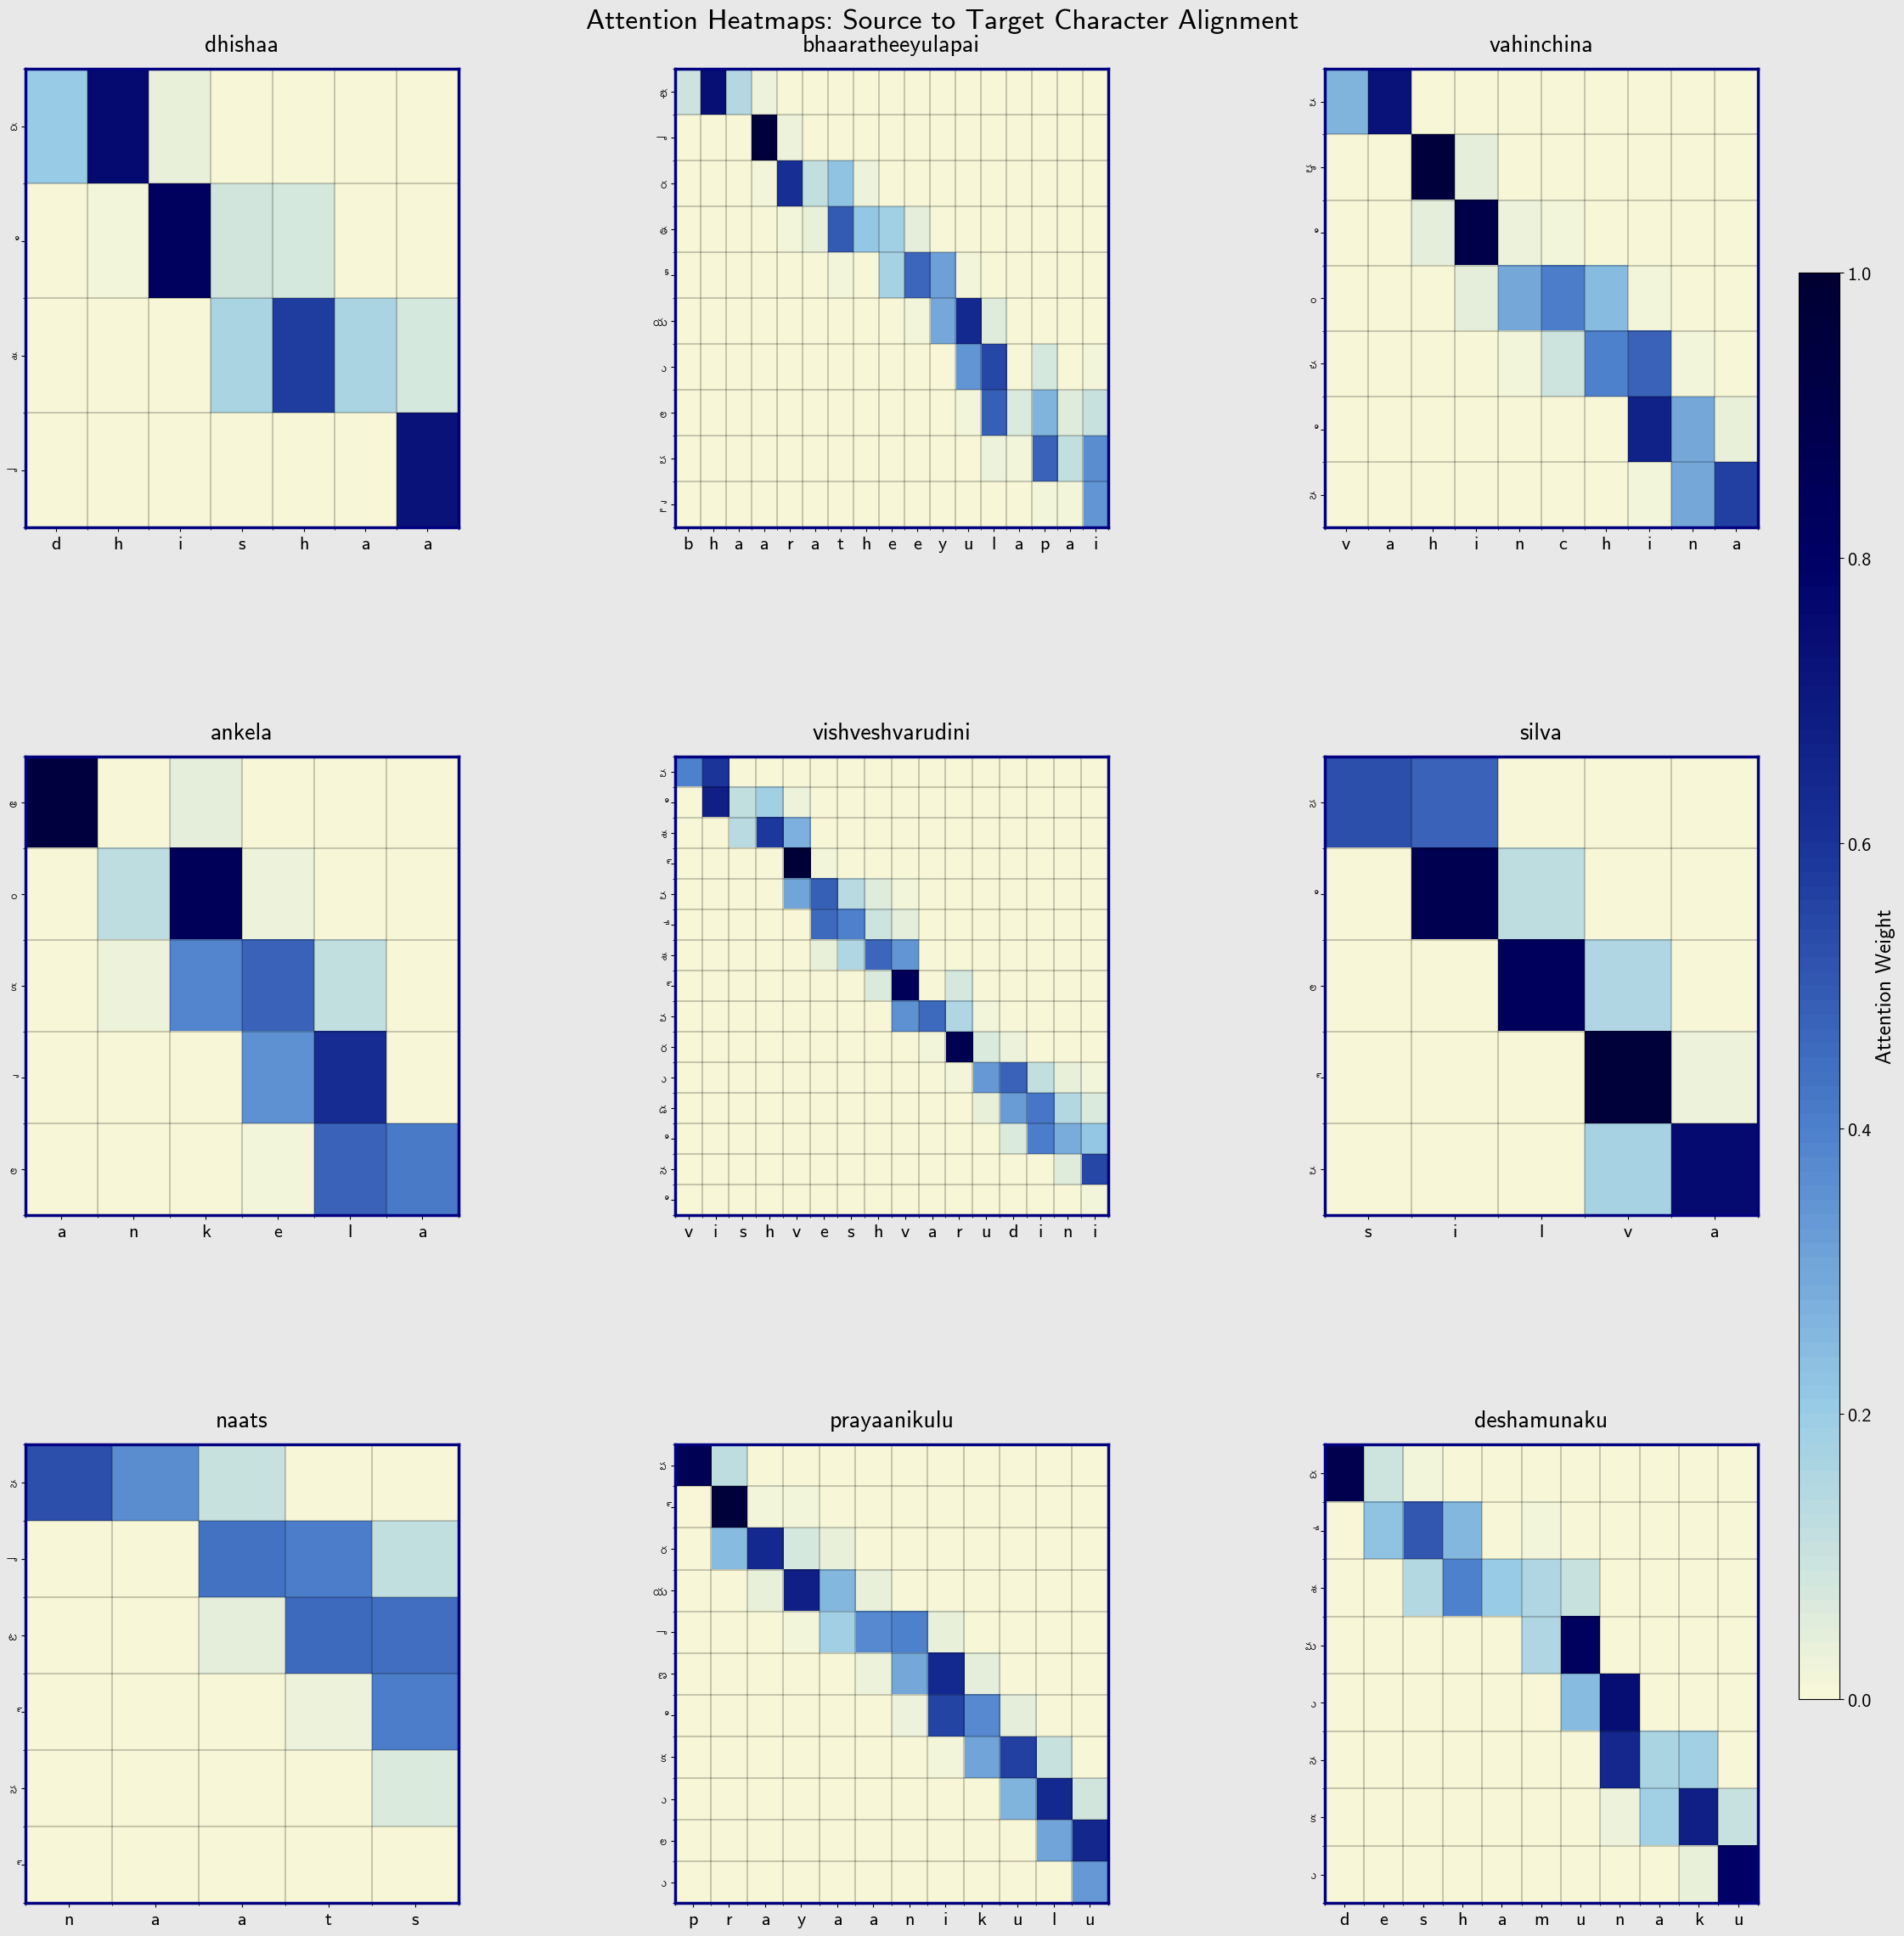


Telugu characters for each word:
dhishaa → దిశా
bhaaratheeyulapai → భారతీయులపై
vahinchina → వహించిన
ankela → అంకెల
vishveshvarudini → విశ్వేశ్వరుడిని
silva → సిల్వ
naats → నాట్స్
prayaanikulu → ప్రయాణికులు
deshamunaku → దేశమునకు


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
import urllib.request

# Create output directory
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Create fonts directory
font_dir = "fonts"
os.makedirs(font_dir, exist_ok=True)

# Download a reliable Telugu font
font_path = os.path.join(font_dir, "Lohit-Telugu.ttf")
if not os.path.exists(font_path):
    try:
        urllib.request.urlretrieve("https://releases.pagure.org/lohit/Lohit-Telugu.ttf", font_path)
        print(f"Downloaded Telugu font to {font_path}")
    except Exception as e:
        print(f"Could not download font: {e}")
        font_path = None

# Register the font with matplotlib
if font_path and os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    telugu_font = fm.FontProperties(fname=font_path)
    print("Telugu font added successfully")
else:
    telugu_font = None
    print("Warning: No Telugu font available")

def tensor_to_numpy(tensor):
    """Safely convert a PyTorch tensor to NumPy array"""
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def generate_attention_heatmaps(model, example_words, src_vocab, tgt_vocab, device, output_file=None):
    """Generate a 3x3 grid of attention heatmaps with darker color visualization"""
    # Create figure with 3x3 grid and more space between plots
    fig, axes = plt.subplots(3, 3, figsize=(24, 24), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
    axes = axes.flatten()
    
    # Create a darker, more intense colormap
    colors = [
        (0.97, 0.97, 0.85),  # Light cream background
        (0.6, 0.8, 0.9),     # Medium light blue
        (0.3, 0.5, 0.8),     # Medium blue
        (0.1, 0.2, 0.6),     # Deep blue
        (0.0, 0.0, 0.4),     # Very dark blue
        (0.0, 0.0, 0.2)      # Near black-blue
    ]
    custom_cmap = LinearSegmentedColormap.from_list('dark_blue', colors, N=100)
    
    # Set a dark background for the figure
    fig.patch.set_facecolor('#E8E8E8')  # Light gray background
    
    # Process examples
    num_examples = min(len(example_words), 9)
    
    # Store all results for later printing
    all_results = []
    
    # Loop through each example word
    for idx, word in enumerate(example_words[:num_examples]):
        ax = axes[idx]
        
        # Run inference
        model.eval()
        
        # Encode the source word
        src_ids = [src_vocab.sos_idx] + [src_vocab.char2idx.get(c, src_vocab.unk_idx) for c in word] + [src_vocab.eos_idx]
        src = torch.tensor([src_ids], device=device)
        src_lens = torch.tensor([len(src_ids)], device=device)
        
        with torch.no_grad():
            # Generate prediction and attention scores
            enc_output, hidden = model.encoder(src, src_lens)
            mask = (src != model.pad_idx)
            input_token = torch.tensor([tgt_vocab.sos_idx], device=device)
            predictions = []
            attentions = []
            
            # Decode one token at a time
            for _ in range(50):
                emb = model.decoder.embedding(input_token.unsqueeze(0))
                
                if model.decoder.cell_type == 'LSTM':
                    dec_h = hidden[0][-1]
                else:
                    dec_h = hidden[-1]
                
                attn_weights = model.decoder.attention(dec_h, enc_output, mask)
                attentions.append(tensor_to_numpy(attn_weights.squeeze()))
                
                context = torch.bmm(attn_weights.unsqueeze(1), enc_output)
                rnn_input = torch.cat((emb, context), dim=2)
                output, hidden = model.decoder.rnn(rnn_input, hidden)
                
                output = output.squeeze(1)
                emb = emb.squeeze(1)
                context = context.squeeze(1)
                
                logits = model.decoder.fc(torch.cat((output, context, emb), dim=1))
                
                top1 = logits.argmax(1).item()
                predictions.append(top1)
                
                input_token = torch.tensor([top1], device=device)
                
                if top1 == tgt_vocab.eos_idx:
                    break
        
        # Get source and target tokens
        source_chars = [c for c in word]
        
        target_indices = [p for p in predictions if p < len(tgt_vocab.idx2char) and 
                         p not in [tgt_vocab.pad_idx, tgt_vocab.sos_idx, tgt_vocab.eos_idx]]
        target_chars = [tgt_vocab.idx2char[i] for i in target_indices]
        
        # Store result for this example
        all_results.append({
            'source': word,
            'target_chars': target_chars,
            'target_str': ''.join(target_chars)
        })
        
        # Stack attention weights
        attention_matrix = np.stack(attentions, axis=0)
        
        # Only keep relevant part (skip special tokens)
        attention_matrix = attention_matrix[:len(target_indices), 1:len(word)+1]
        
        # Create the heatmap with sharper edges and darker colors
        im = ax.imshow(attention_matrix, cmap=custom_cmap, aspect='auto', vmin=0, vmax=1, interpolation='nearest')
        
        # Add grid lines to the heatmap for better visibility
        ax.set_xticks(np.arange(-.5, len(source_chars), 1), minor=True)
        ax.set_yticks(np.arange(-.5, len(target_indices), 1), minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=1.5, alpha=0.2)
        
        # Set background color for the subplot
        ax.set_facecolor('#F5F5F5')  # Very light gray
        
        # Set x-axis ticks and labels (source)
        ax.set_xticks(np.arange(len(source_chars)))
        ax.set_xticklabels(source_chars, fontsize=16, fontweight='bold')
        
        # Set y-axis ticks and labels with Telugu characters
        ax.set_yticks(np.arange(len(target_indices)))
        if telugu_font:
            # Make Telugu characters larger for better visibility
            ax.set_yticklabels(target_chars, fontsize=18, fontproperties=telugu_font)
        else:
            ax.set_yticklabels([f"{c}" for c in target_chars], fontsize=18)
        
        # Set title with slightly larger font
        ax.set_title(word, fontsize=20, pad=15, fontweight='bold')
        
        # Add border around the subplot
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2.5)
            spine.set_color('navy')
    
    # Add a colorbar at the right side
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Attention Weight', fontsize=18, fontweight='bold')
    cbar.ax.tick_params(labelsize=16)
    
    # Add main title to the figure
    fig.suptitle('Attention Heatmaps: Source to Target Character Alignment', 
                fontsize=24, fontweight='bold', y=0.98)
    
    # Adjust margins manually
    plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.4)
    
    # Save figure with higher resolution
    if output_file:
        plt.savefig(output_file, dpi=600, bbox_inches='tight')
        print(f"Saved high-resolution attention heatmaps to {output_file}")
    
    plt.show()
    
    # Print the correct Telugu characters for each word
    print("\nTelugu characters for each word:")
    for result in all_results:
        print(f"{result['source']} → {result['target_str']}")

# Example words for a 3x3 grid
example_words = ["dhishaa", "bhaaratheeyulapai", "vahinchina", 
                 "ankela", "vishveshvarudini", "silva", 
                 "naats", "prayaanikulu", "deshamunaku"]

# Generate enhanced dark blue heatmaps
output_file = os.path.join(output_dir, "attention_heatmaps_dark.png")
generate_attention_heatmaps(model, example_words, src_vocab, tgt_vocab, device, output_file)

Telugu font added successfully
Creating beautiful enhanced animation
Source: hyderaabaadii
Target (Telugu): హైదరాబాది
Source: deshamunaku
Target (Telugu): దేశమునకు
Source: sevalandincharu
Target (Telugu): సేవలందించారు


/tmp/ipykernel_35/3591680974.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 0.96])
/tmp/ipykernel_35/3591680974.py:298: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_35/3591680974.py:298: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.draw()


Saved infinitely looping animation to output/enhanced_animation.gif



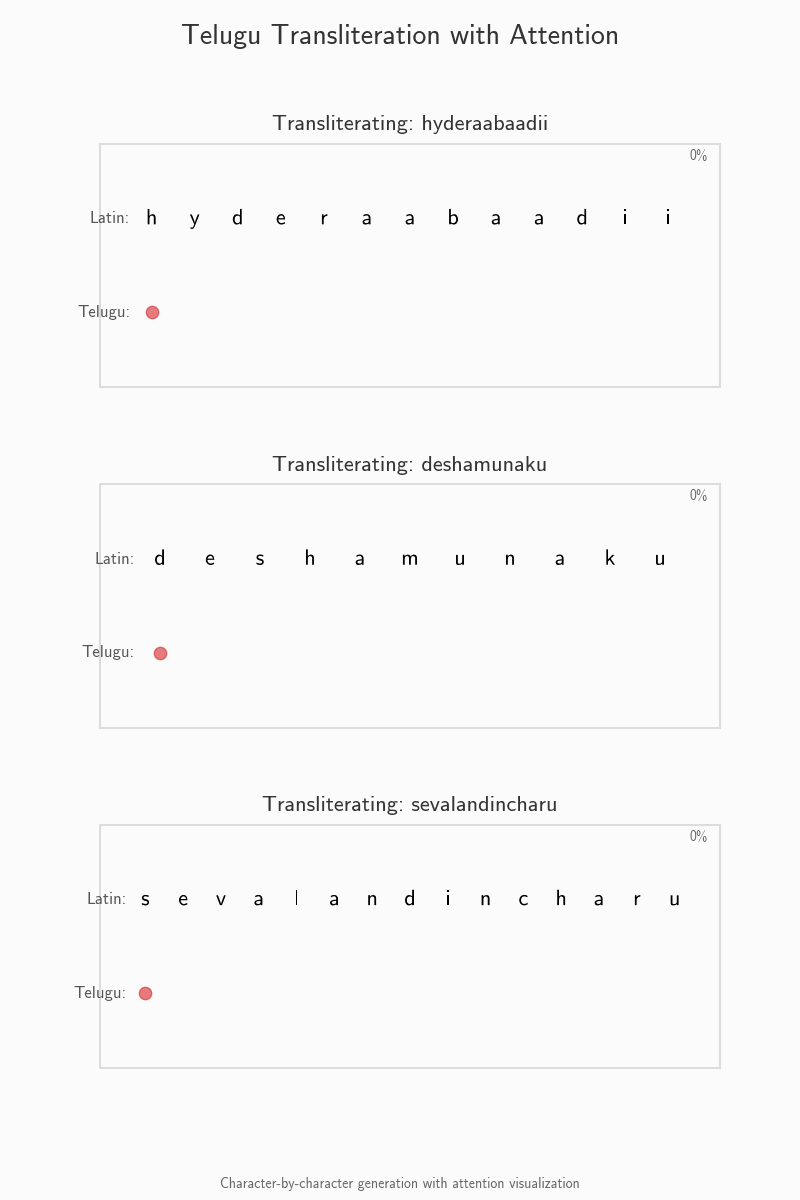

Infinitely looping enhanced animation displayed above


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import matplotlib.font_manager as fm
import urllib.request
import imageio
from matplotlib.colors import to_rgba, LinearSegmentedColormap
from IPython.display import display, HTML
import base64
import io
from PIL import Image, ImageDraw, ImageFont
from matplotlib.patches import FancyBboxPatch, BoxStyle
import matplotlib.patheffects as path_effects

# Create output directory
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Create fonts directory
font_dir = "fonts"
os.makedirs(font_dir, exist_ok=True)

# Download a reliable Telugu font
font_path = os.path.join(font_dir, "Lohit-Telugu.ttf")
if not os.path.exists(font_path):
    try:
        urllib.request.urlretrieve("https://releases.pagure.org/lohit/Lohit-Telugu.ttf", font_path)
        print(f"Downloaded Telugu font to {font_path}")
    except Exception as e:
        print(f"Could not download font: {e}")
        font_path = None

# Register the font with matplotlib
if font_path and os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    telugu_font = fm.FontProperties(fname=font_path)
    print("Telugu font added successfully")
else:
    telugu_font = None
    print("Warning: No Telugu font available")

def tensor_to_numpy(tensor):
    """Safely convert a PyTorch tensor to NumPy array"""
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def process_word(model, word, src_vocab, tgt_vocab, device):
    """Process a single word and return its attention data"""
    # Run inference on the word
    model.eval()
    
    # Encode the source word
    src_ids = [src_vocab.sos_idx] + [src_vocab.char2idx.get(c, src_vocab.unk_idx) for c in word] + [src_vocab.eos_idx]
    src = torch.tensor([src_ids], device=device)
    src_lens = torch.tensor([len(src_ids)], device=device)
    
    with torch.no_grad():
        # Get encoder outputs
        enc_output, hidden = model.encoder(src, src_lens)
        mask = (src != model.pad_idx)
        input_token = torch.tensor([tgt_vocab.sos_idx], device=device)
        predictions = []
        attentions = []
        
        # Decode one token at a time
        for _ in range(50):
            emb = model.decoder.embedding(input_token.unsqueeze(0))
            
            if model.decoder.cell_type == 'LSTM':
                dec_h = hidden[0][-1]
            else:
                dec_h = hidden[-1]
            
            attn_weights = model.decoder.attention(dec_h, enc_output, mask)
            attentions.append(tensor_to_numpy(attn_weights.squeeze()))
            
            context = torch.bmm(attn_weights.unsqueeze(1), enc_output)
            rnn_input = torch.cat((emb, context), dim=2)
            output, hidden = model.decoder.rnn(rnn_input, hidden)
            
            output = output.squeeze(1)
            emb = emb.squeeze(1)
            context = context.squeeze(1)
            
            logits = model.decoder.fc(torch.cat((output, context, emb), dim=1))
            
            top1 = logits.argmax(1).item()
            predictions.append(top1)
            
            input_token = torch.tensor([top1], device=device)
            
            if top1 == tgt_vocab.eos_idx:
                break
    
    # Get source and target characters
    source_chars = [c for c in word]
    
    target_indices = [p for p in predictions if p < len(tgt_vocab.idx2char) and 
                      p not in [tgt_vocab.pad_idx, tgt_vocab.sos_idx, tgt_vocab.eos_idx]]
    target_chars = [tgt_vocab.idx2char[i] for i in target_indices]
    
    # Get attention weights (skip special tokens)
    attention_matrix = np.stack(attentions, axis=0)
    attention_matrix = attention_matrix[:len(target_indices), 1:len(word)+1]
    
    # Generate frames for this word
    target_str = ''.join(target_chars)
    print(f"Source: {word}")
    print(f"Target (Telugu): {target_str}")
    
    return {
        'source': word,
        'target': target_str,
        'target_chars': target_chars,
        'source_chars': source_chars,
        'attention_matrix': attention_matrix
    }

def create_enhanced_animation(model, words, src_vocab, tgt_vocab, device, output_file=None, fps=5.0, display_inline=True):
    """
    Create an enhanced visualization with top-to-bottom arrangement,
    beautiful colors, boxed Telugu characters, and smooth animations.
    Only shows attention lines for the current character being generated.
    """
    # Process all words
    word_data = [process_word(model, word, src_vocab, tgt_vocab, device) for word in words]
    
    # Get the maximum sequence length for consistent animation length
    max_target_len = max(len(data['target_chars']) for data in word_data)
    
    # Prepare frames for the animation
    all_frames = []
    fig_width, fig_height = 800, 1200  # Fixed pixel dimensions for all frames
    
    # Create custom colormaps for the attention lines
    # Beautiful gradients from teal to purple
    colors1 = [(0.0, 0.6, 0.9, 0.7),   # Light teal
               (0.0, 0.4, 0.8, 0.8),   # Medium blue 
               (0.2, 0.2, 0.8, 0.9)]   # Deep blue-purple
    
    colors2 = [(0.8, 0.4, 0.0, 0.7),   # Orange
               (0.9, 0.2, 0.2, 0.8),   # Red-orange
               (0.7, 0.0, 0.4, 0.9)]   # Deep red-purple
    
    colors3 = [(0.0, 0.7, 0.4, 0.7),   # Teal-green
               (0.0, 0.5, 0.3, 0.8),   # Deep green
               (0.0, 0.3, 0.4, 0.9)]   # Deep teal
    
    # Create different colormaps for each word
    colormaps = [
        LinearSegmentedColormap.from_list('teal_to_purple', colors1),
        LinearSegmentedColormap.from_list('orange_to_red', colors2),
        LinearSegmentedColormap.from_list('green_to_teal', colors3)
    ]
    
    # Generate frames - one frame per step
    for step in range(max_target_len + 1):
        # Create figure with 3 rows, one for each word
        fig, axes = plt.subplots(3, 1, figsize=(8, 12), gridspec_kw={'hspace': 0.4})
        fig.patch.set_facecolor('#f8f8f8')  # Light background for the entire figure
        
        # Process each word in its own subplot
        for idx, (data, ax, cmap) in enumerate(zip(word_data, axes, colormaps)):
            word = data['source']
            source_chars = data['source_chars']
            target_chars = data['target_chars']
            attention_matrix = data['attention_matrix']
            
            # Set background color for this subplot
            ax.set_facecolor('#ffffff')  # White background
            
            # Space between characters
            char_spacing = 1.0
            
            # Calculate x-coordinates for source characters (evenly spaced)
            source_x = np.arange(len(source_chars)) * char_spacing
            source_y = 1.0
            
            # For each target character, find the source character with max attention
            target_x = []
            for i in range(len(target_chars)):
                # Find source position with max attention
                max_idx = np.argmax(attention_matrix[i])
                target_x.append(source_x[max_idx])
            
            target_y = 0.0
            
            # Add subtle grid for better visual structure
            ax.grid(True, linestyle='--', alpha=0.15)
            
            # Plot source characters with enhanced styling
            for i, char in enumerate(source_chars):
                text = ax.text(source_x[i], source_y, char, 
                        ha='center', va='center', fontsize=16, fontweight='bold')
                # Add a subtle shadow effect
                text.set_path_effects([
                    path_effects.withStroke(linewidth=3, foreground='white')
                ])
            
            # Plot all previously generated target characters (without attention lines)
            for i in range(min(step, len(target_chars))):
                # Add fancy box around Telugu character
                bbox = BoxStyle("Round", pad=0.3, rounding_size=0.2)
                box = FancyBboxPatch(
                    (target_x[i]-0.25, target_y-0.25), 0.5, 0.5, 
                    boxstyle=bbox, fc='#f0f0f0', ec='#bbbbbb', lw=1.5, alpha=0.9
                )
                ax.add_patch(box)
                
                # Add the Telugu character with enhanced styling
                if telugu_font:
                    text = ax.text(target_x[i], target_y, target_chars[i], 
                            ha='center', va='center', fontsize=18, color='#d62728',
                            fontproperties=telugu_font, fontweight='bold')
                    # Add glow effect
                    text.set_path_effects([
                        path_effects.withStroke(linewidth=3, foreground='white')
                    ])
                else:
                    # Fallback - display the Unicode codepoint
                    ax.text(target_x[i], target_y, f"U+{ord(target_chars[i]):04X}", 
                           ha='center', va='center', fontsize=12, color='red')
            
            # Draw attention lines ONLY for the current character (step-1)
            current_char_idx = step - 1
            if current_char_idx >= 0 and current_char_idx < len(target_chars):
                for j, src_x in enumerate(source_x):
                    weight = attention_matrix[current_char_idx, j]
                    if weight > 0.05:  # Only show significant connections
                        # Get color from the custom colormap
                        color = cmap(weight)
                        
                        # Create line with varying thickness based on attention weight
                        line = ax.plot([src_x, target_x[current_char_idx]], [source_y, target_y], 
                                '-', color=color, linewidth=weight*6, alpha=0.8,
                                solid_capstyle='round')
                
                # Add a highlight to the current character being generated
                highlight = plt.Circle((target_x[current_char_idx], target_y), 0.3, 
                                     fill=False, color='#d62728', linewidth=2, 
                                     alpha=0.7, zorder=100)
                ax.add_patch(highlight)
            
            # If we're in the middle of generating a character, show an animated cursor
            if step < len(target_chars):
                cursor_pos = min(step, len(target_x)-1) if target_x else 0
                # Add a pulsing cursor with a subtle animation effect
                cursor_alpha = 0.6 + 0.4 * np.sin(step * np.pi/2)  # Pulsing effect
                ax.scatter([target_x[cursor_pos] if target_x else 0], 
                          [target_y], color='#d62728', s=80, alpha=cursor_alpha, 
                          zorder=100, marker='o')
            
            # Set axis limits and remove ticks
            if source_x.size > 0:
                margin = 1.2  # Add margin for better appearance
                ax.set_xlim(min(source_x) - margin, max(source_x) + margin)
            ax.set_ylim(-0.8, 1.8)
            
            # Add attractive title and axis labels
            ax.set_title(f"Transliterating: {word}", fontsize=16, fontweight='bold', 
                        color='#333333', pad=10)
            
            # Add labels for source and target
            ax.text(-0.5, source_y, "Latin:", fontsize=12, ha='right', va='center', 
                    fontweight='bold', color='#555555')
            ax.text(-0.5, target_y, "Telugu:", fontsize=12, ha='right', va='center', 
                    fontweight='bold', color='#555555')
            
            # Remove axis ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add decorative border around the subplot
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(1.5)
                spine.set_color('#dddddd')
            
            # Progress indicator
            if len(target_chars) > 0:
                progress = min(step, len(target_chars)) / len(target_chars)
                ax.text(0.98, 0.98, f"{int(progress*100)}%", 
                        transform=ax.transAxes, ha='right', va='top',
                        fontsize=10, color='#666666')
        
        # Add overall title to the figure
        fig.suptitle("Telugu Transliteration with Attention", fontsize=20, 
                    fontweight='bold', color='#333333', y=0.98)
        
        # Add subtle footer
        plt.figtext(0.5, 0.01, "Character-by-character generation with attention visualization", 
                   ha='center', fontsize=10, color='#666666')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.96])
        
        # Save this frame to memory with fixed size
        fig.canvas.draw()
        
        # Convert to PIL Image to ensure all frames have the same size
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100)
        buf.seek(0)
        pil_img = Image.open(buf).resize((fig_width, fig_height))
        
        # Convert to numpy array
        frame = np.array(pil_img)
        all_frames.append(frame)
        
        plt.close(fig)
    
    # Save as GIF with infinite looping
    if output_file:
        # loop=0 means loop infinitely
        imageio.mimsave(output_file, all_frames, fps=fps, loop=0)
        print(f"Saved infinitely looping animation to {output_file}")
    
    # Display the animation inline if requested
    if display_inline:
        try:
            # Create an in-memory stream for the GIF
            gif_buffer = io.BytesIO()
            imageio.mimsave(gif_buffer, all_frames, format='GIF', fps=fps, loop=0)
            gif_buffer.seek(0)
            
            # Encode the GIF to base64 for HTML display
            gif_data = base64.b64encode(gif_buffer.read()).decode('utf-8')
            
            # Display the GIF using HTML with infinite looping
            display(HTML(f'<img src="data:image/gif;base64,{gif_data}" alt="Enhanced animation" />'))
            print(f"Infinitely looping enhanced animation displayed above")
        except Exception as e:
            print(f"Could not display animation inline: {e}")
            print(f"Animation saved to {output_file}")
    
    # Return the frames for further use if needed
    return all_frames
# Words to visualize
words_to_visualize = [
    "hyderaabaadii",
    "deshamunaku",
    "sevalandincharu"
]

# Create an enhanced visualization
output_file = os.path.join(output_dir, "enhanced_animation.gif")
print("Creating beautiful enhanced animation")
frames = create_enhanced_animation(model, words_to_visualize, src_vocab, tgt_vocab, device, output_file, fps=5.0, display_inline=True)